# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
        self.loss_history = []
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        ones = np.ones(len(X))
        return ones / (ones + np.exp(-np.sum(weights.T * X, axis=1)))

    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        '''
        n_samples = x.shape[0]
        log_part = 0
        for i in range(n_samples):
            log_part += np.log(1 + np.exp(-np.sum(weights * x[i]) * y[i]))
        result = log_part / n_samples + (np.square(weights)).sum() / (2 * self.C)
        '''
        return sum(np.log(1 + np.exp(-(x @ weights) * y)))/len(y) + (np.square(weights)).sum() / (2 * self.C)  
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:weights
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.loss_history = []
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        num_samples = X_ext.shape[0]
        ones = np.ones(num_samples)
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization

        for i in range(self.max_iter):
            #delta = np.sum(y * X_ext.T * (ones - ones / (ones + np.exp(-np.sum(self.weights_.T * X_ext) * y))), axis=1) / num_samples - self.weights_ / self.C  #"<your code>"
            delta =X_ext.T @ ( y *  (ones - ones / (ones + np.exp(-(X_ext @ self.weights_) * y))) / num_samples) - self.weights_ / self.C  #"<your code>"
            '''
            delta = []
            for f in range(num_features): 
                fsum = 0.0
                for s in range(num_samples):
                    fsum = fsum + y[s] * X_ext[s][f] * (1 - (1 / (1 + np.exp(-self.weights_.T[f] * X_ext[s][f] * y[s]))))
                delta.append(fsum / num_samples - self.weights_[f] / self.C)
            delta = np.array(delta)
            #'''
            self.weights_ -= - self.eta * delta
            self.weights_ = np.around(self.weights_, decimals = 7)
            self.loss_history.append(self.get_loss(X_ext, self.weights_, y))
            #print(self.loss_history)
            if (np.sqrt(np.square(self.eta * delta).sum())) < self.tol: #"<your code>":
                break

    #delta =  y[i] * X_ext[i] * (1 -1 / (1 + np.exp(-y[i] * (np.dot(X_ext[i], self.weights_[i])))))

    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        predict = []
        for i in self.predict_proba(X):
            if i >= 0.5:
                predict.append(1)
            else:
                predict.append(-1)
        return np.array(predict)

In [5]:
from sklearn import datasets
from sklearn import metrics

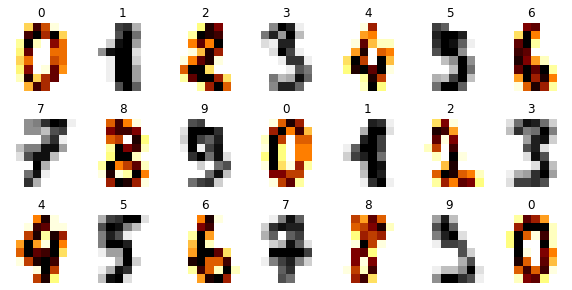

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

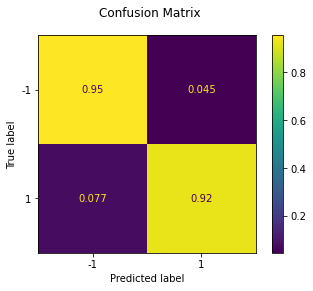

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

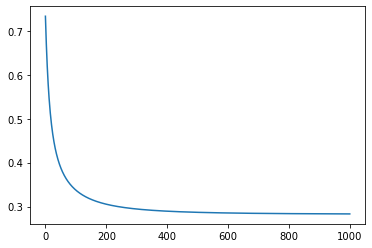

In [17]:
## your code
plt.plot(model.loss_history)

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

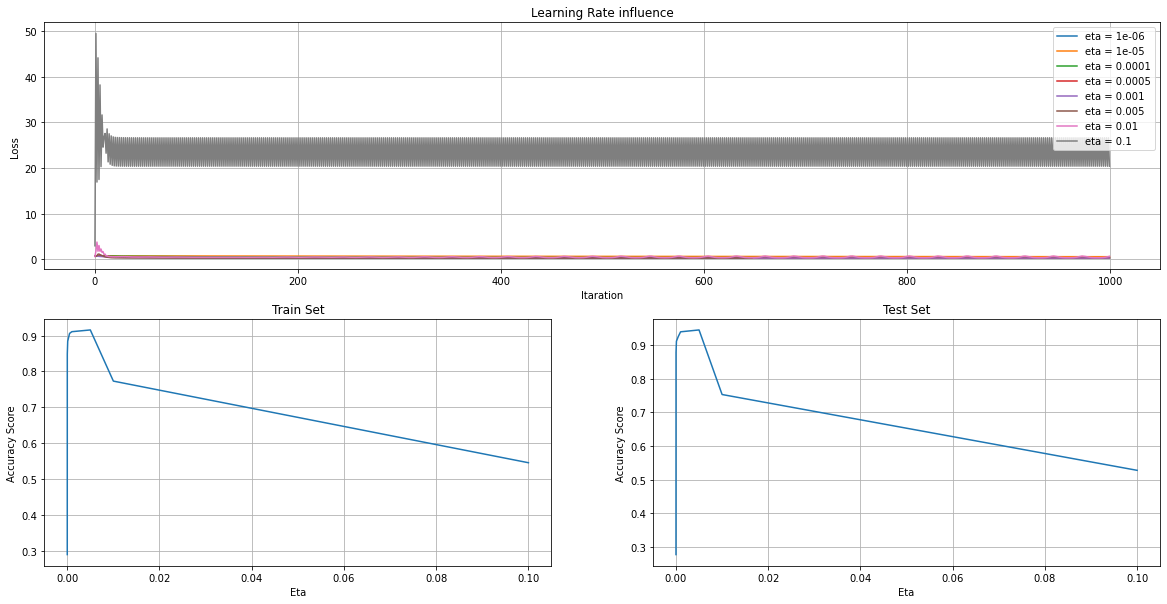

In [18]:
## your code
train_acc = []
test_acc = []
etas = [ 0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1 ]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for eta_v in etas:
    model_eta = CustomLogisticRegression(eta=eta_v)
    model_eta.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_test), y_true=y_test))
    ax_1.plot(model_eta.loss_history, label=f'eta = {eta_v}')
    ax_1.legend(loc='best')
ax_1.set_title('Learning Rate influence')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(etas, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('Eta')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(etas, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('Eta')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

The graphics show that too small or too high values of Eta make the model worse because Accuracy Score is decreasing.


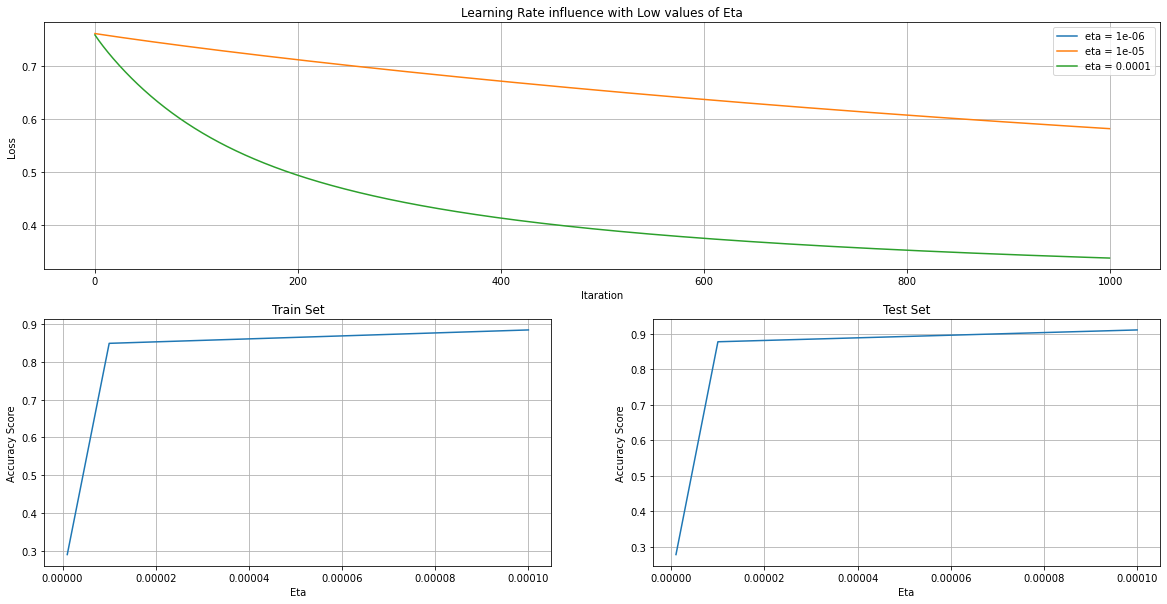

In [20]:
## your code
train_acc = []
test_acc = []
etas = [ 0.000001, 0.00001, 0.0001]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for eta_v in etas:
    model_eta = CustomLogisticRegression(eta=eta_v)
    model_eta.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_test), y_true=y_test))
    ax_1.plot(model_eta.loss_history, label=f'eta = {eta_v}')
    ax_1.legend(loc='best')
ax_1.set_title('Learning Rate influence with Low values of Eta')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(etas, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('Eta')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(etas, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('Eta')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

I would like to do attention that there is no like for the eta = 1e-06. It seems the eta makes 'weights' are to small.

In [21]:
model_eta = CustomLogisticRegression(eta=0.000001)
model_eta.fit(X_train, y_train)
print(model_eta.weights_)
print(model_eta.loss_history)
train_acc = metrics.accuracy_score(y_pred=model_eta.predict(X_train), y_true=y_train)
test_acc = metrics.accuracy_score(y_pred=model_eta.predict(X_test), y_true=y_test)
print(train_acc, test_acc)

[-1.9301e-03  6.9341e-03  3.5692e-03  1.5186e-03 -5.2913e-03 -5.2914e-03
 -6.7970e-03  5.6342e-03  1.5557e-03  3.2011e-03 -7.3753e-03  7.2300e-03
  5.1144e-03 -4.4247e-03 -4.8935e-03 -4.8701e-03 -3.0116e-03  3.8090e-04
 -1.0469e-03 -3.2123e-03  1.7207e-03 -5.5450e-03 -3.1969e-03 -2.0560e-03
 -6.7580e-04  4.3873e-03 -4.6206e-03  2.1860e-04  1.4231e-03 -6.9758e-03
  1.6554e-03 -5.0689e-03 -6.6915e-03  6.9059e-03  7.1629e-03  4.7436e-03
 -3.0056e-03 -6.1888e-03  2.8351e-03 -9.2070e-04 -5.8148e-03 -7.4200e-05
 -7.1638e-03  6.2952e-03 -3.7117e-03  2.5008e-03 -2.8966e-03  3.0860e-04
  7.1860e-04 -4.8484e-03  7.2243e-03  4.2319e-03  6.7613e-03  6.0744e-03
  1.5059e-03  6.4900e-03 -6.3309e-03 -4.6772e-03 -6.9965e-03 -2.6863e-03
 -1.7120e-03 -3.5181e-03  5.0571e-03 -2.2041e-03 -3.3703e-03]
[0.7610729330548688]
0.2894919972164231 0.2777777777777778


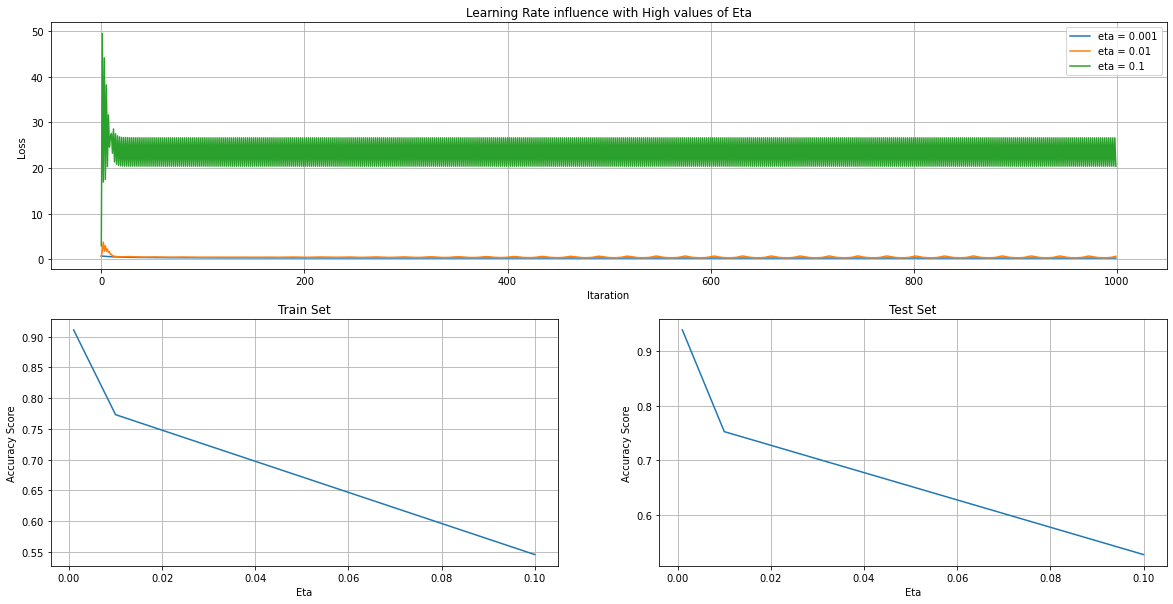

In [22]:
## your code
train_acc = []
test_acc = []
etas = [ 0.001, 0.01, 0.1]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for eta_v in etas:
    model_eta = CustomLogisticRegression(eta=eta_v)
    model_eta.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_test), y_true=y_test))
    ax_1.plot(model_eta.loss_history, label=f'eta = {eta_v}')
    ax_1.legend(loc='best')
ax_1.set_title('Learning Rate influence with High values of Eta')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(etas, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('Eta')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(etas, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('Eta')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

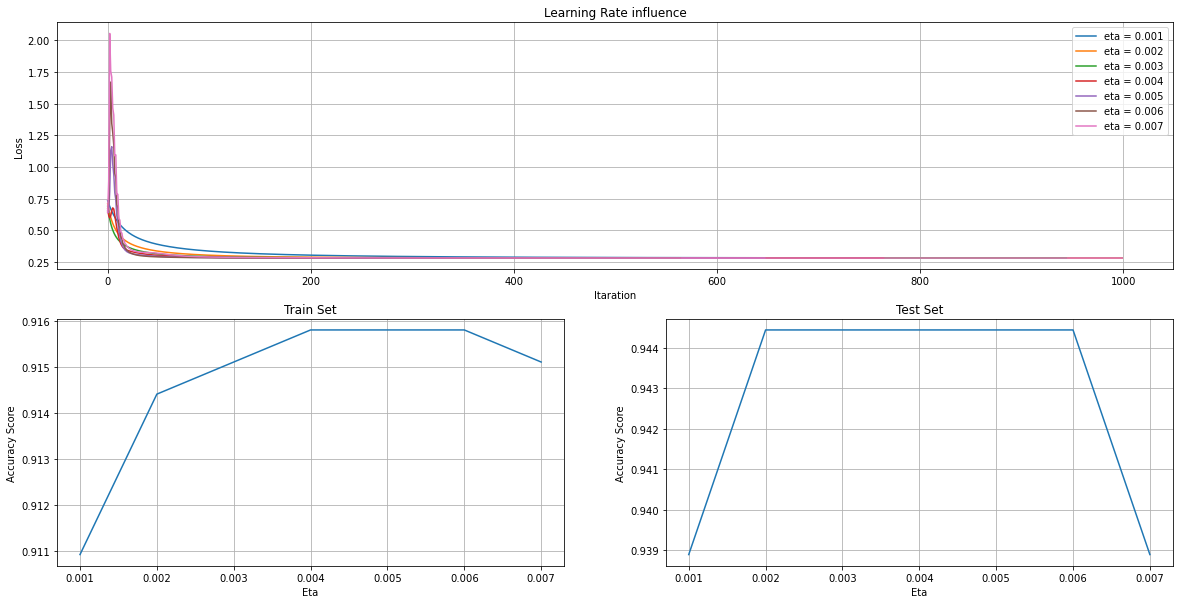

In [23]:
## your code
train_acc = []
test_acc = []
etas = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007 ]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for eta_v in etas:
    model_eta = CustomLogisticRegression(eta=eta_v)
    model_eta.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model_eta.predict(X_test), y_true=y_test))
    ax_1.plot(model_eta.loss_history, label=f'eta = {eta_v}')
    ax_1.legend(loc='best')
ax_1.set_title('Learning Rate influence')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(etas, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('Eta')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(etas, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('Eta')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

< your thoughts >
The experiment shows that too small or too high values of Eta make the model worse because Accuracy Score is decreasing. 
* When Eta is too small, a model will get weights also too small after one or several iterations.
* When Eta is too high, the Loss function looks like the sinusoid function or gets some noises. In this case, Accuracy Score is decreased.
* Eta values are near the default eta = 0.001 does not have a big dispersion. I found out that Eta from { 0.004, 0.005, 0.006} shows the higher Accuracy Score.

**(0.5 points)** Try different regularization parameter values and compare the model quality.

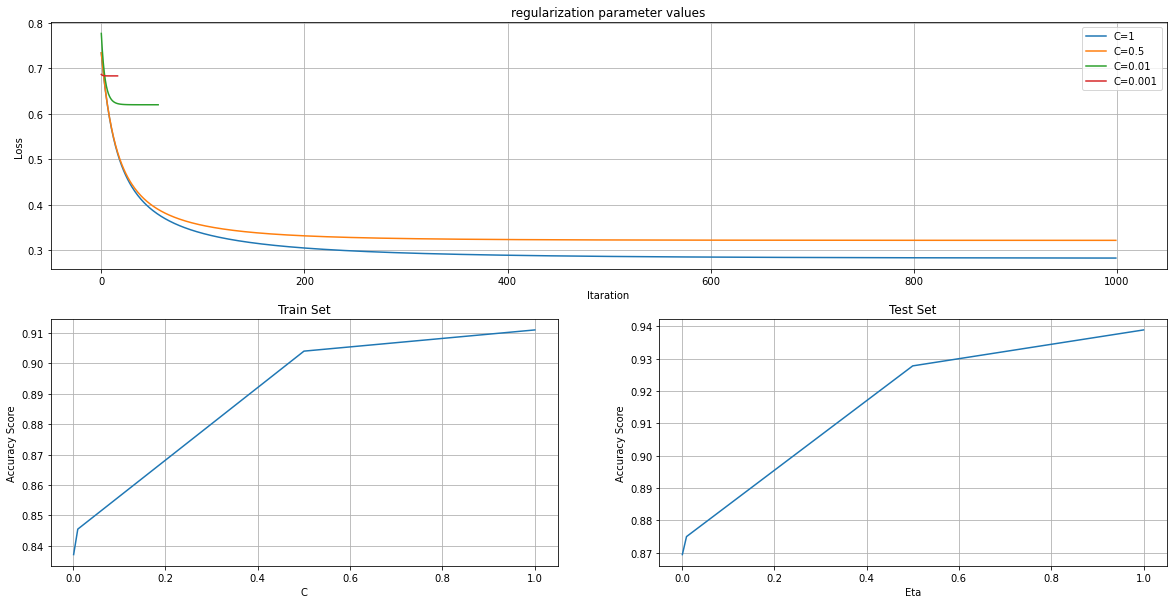

In [24]:
## your code
## your code
train_acc = []
test_acc = []
C_arr = [1, 0.5, 0.01, 0.001]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for c in C_arr:
    model = CustomLogisticRegression(eta=0.001, C=c)
    model.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    ax_1.plot(model.loss_history, label=f'C={c}')
    ax_1.legend(loc='best')
ax_1.set_title('regularization parameter values')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(C_arr, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('C')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(C_arr, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('Eta')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

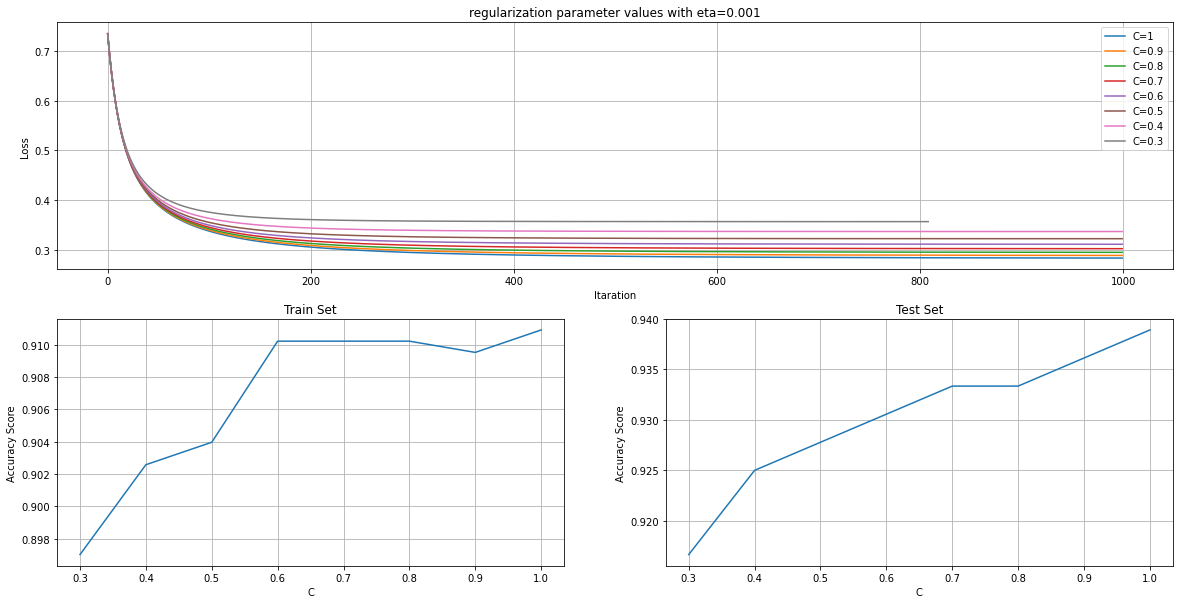

In [25]:
## your code
## your code
train_acc = []
test_acc = []
C_arr = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for c in C_arr:
    model = CustomLogisticRegression(eta=0.001, C=c)
    model.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    ax_1.plot(model.loss_history, label=f'C={c}')
    ax_1.legend(loc='best')
ax_1.set_title(f'regularization parameter values with eta={0.001}')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(C_arr, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('C')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(C_arr, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('C')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

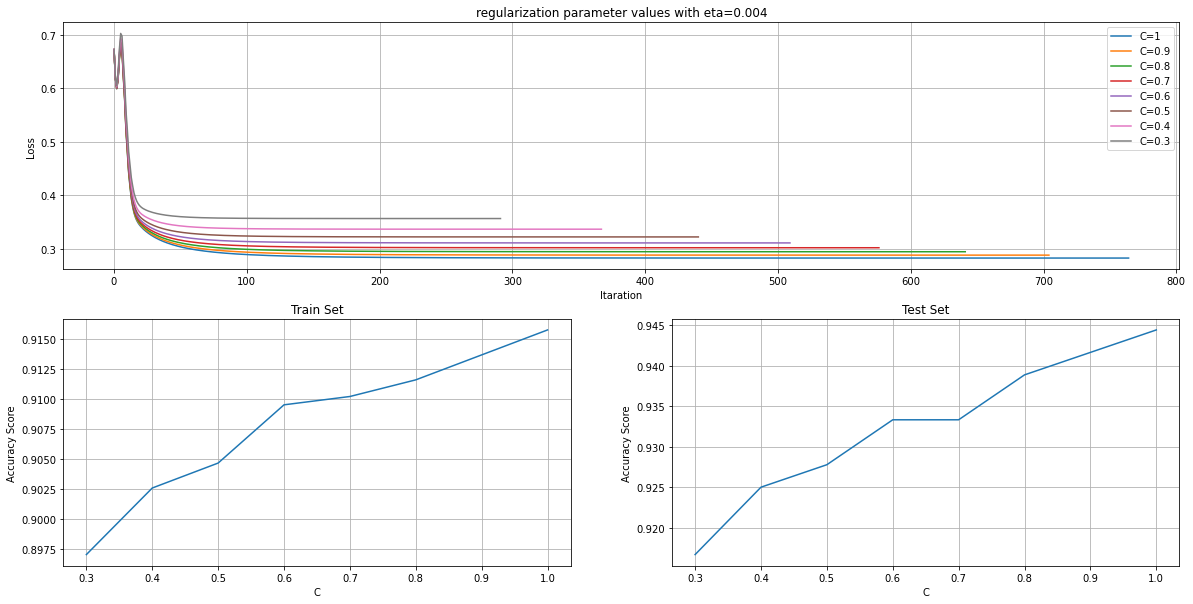

In [26]:
## your code
## your code
train_acc = []
test_acc = []
C_arr = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3]
fig = plt.figure(figsize=(20, 10))
ax_1 = fig.add_subplot(2, 1, 1)
ax_2 = fig.add_subplot(2, 2, 3)
ax_3 = fig.add_subplot(2, 2, 4)

ax.grid()
for c in C_arr:
    model = CustomLogisticRegression(eta=0.004, C=c)
    model.fit(X_train, y_train)
    train_acc.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))
    test_acc.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    ax_1.plot(model.loss_history, label=f'C={c}')
    ax_1.legend(loc='best')
ax_1.set_title(f'regularization parameter values with eta={0.004}')
ax_1.set_xlabel('Itaration')
ax_1.set_ylabel('Loss')
ax_2.plot(C_arr, train_acc)
ax_2.set_title('Train Set')
ax_2.set_xlabel('C')
ax_2.set_ylabel('Accuracy Score')
ax_3.plot(C_arr, test_acc)
ax_3.set_title('Test Set')
ax_3.set_xlabel('C')
ax_3.set_ylabel('Accuracy Score')
ax_1.grid()
ax_2.grid()
ax_3.grid()
plt.show()

< your thoughts >

**(0.5 points)** Compare zero initialization and random initialization. 

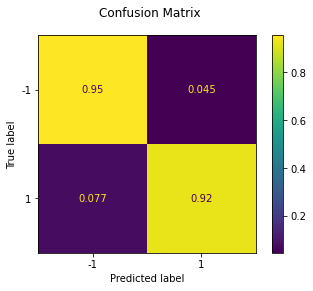

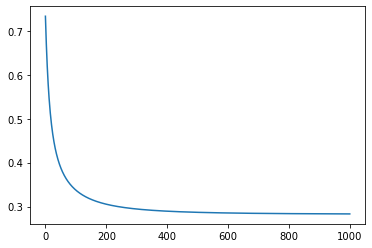

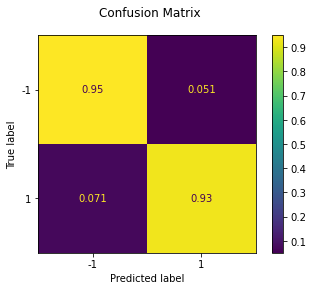

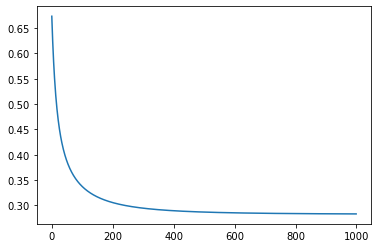

In [27]:
## your code
model = CustomLogisticRegression(zero_init=False)
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
plt.plot(model.loss_history)

modelz = CustomLogisticRegression(zero_init=True)
train_acc, test_acc = fit_evaluate(modelz, X_train, y_train, X_test, y_test)
plt.plot(modelz.loss_history)


< your thoughts >

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [28]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        P = np.add.outer(np.sum(X**2, axis=1), np.sum(Y**2, axis=1))
        N = np.dot(X, Y.T)
        return np.sqrt(P - 2*N)
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        p = np.zeros(len(self.classes_))
        i = 0
        for curr in y:
            idx = np.where(self.classes_ == np.array(curr))[0][0]
            p[idx] += weights[i]
            i += 1
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
    def get_neighbors(self, P):
        y = []
        p = []
        Py = pd.concat([pd.DataFrame(P.T), pd.DataFrame(self.y)], axis=1)
        for curr_class in self.classes_:
            #curr_Py = np.where(Py.index == np.array(curr_class))
            #temp = np.partition(-Py[Py.index == curr_class], 2)         
            #result = -temp[:2]
            curr_Py = Py[Py.index == curr_class]
            sorted_Py = np.sort(curr_Py, axis=None)        
            for i in range(self.n_neighbors):
                p.append(sorted_Py[(-i-2):(-i-1)][0])
                y.append(curr_class)
            #np.concatenate(np.array(y), np.array(np.full((1, 2), curr_class)))
            #print('dist: ', curr_Py)
            #print('p:', p)
            #print('y:', y)
            #curr_array = curr_Py.reshape()
            #print('curr_arr :', curr_array)
        return np.array(y), np.array(p)
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            #print ('distance:', P.shape, P)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                #weights_of_points = np.sum(1 / (self.eps + P), axis=1)                
                curr_y, curr_p = self.get_neighbors(P)
                weights_of_points = 1 / (self.eps + curr_p)
                
            '''
            print('y shape:', self.y.shape)
            print('weights:', weights_of_points.shape)
            print(weights_of_points)
            class_weights = self.get_class_weights(self.y, weights_of_points)
            prob = class_weights / sum(weights_of_points) 

'''
            #print('weights_of_points', weights_of_points)
            #print('curr_y', curr_y)
            class_weights = self.get_class_weights(curr_y, weights_of_points)        
            prob = class_weights / sum(weights_of_points) 
            return np.where(prob * X > 0.5, 1, 0)
            pass
        
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        prob = self.predict_proba(X)
        return prob
        pass

In [29]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [30]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [31]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

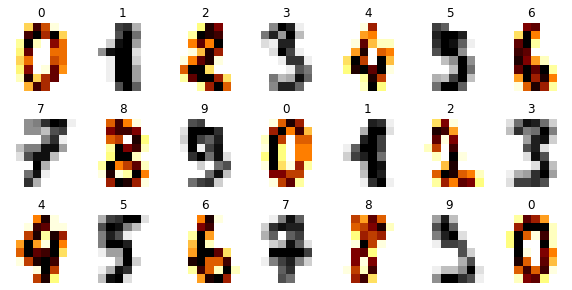

In [32]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [34]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [ ]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [ ]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [ ]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

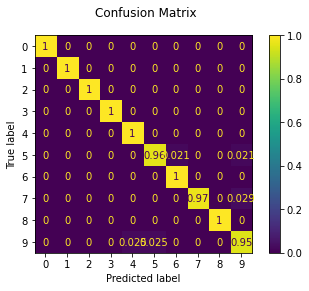

In [36]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, list(map(str, y_train)));
lr_best_clf, lr_stats = fit_evaluate(knn, X_train, y_train, X_test, y_test)

< your thoughts > there is confusion when the writing of digits is similar.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [37]:
## your code
proba_count = []
accuracy = []
accuracy_trn = []
curr_proba = 0
for neighbors in range(1, 40):
    model = KNeighborsClassifier(n_neighbors=neighbors, weights='distance')
    model.fit(X_train, y_train)
    curr_proba = model.predict_proba(X_test)
    proba_count.append(np.count_nonzero(curr_proba == 1))
    accuracy.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    accuracy_trn.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))

Text(0.5, 1.0, "Count of '1' relates to Neighbors count")

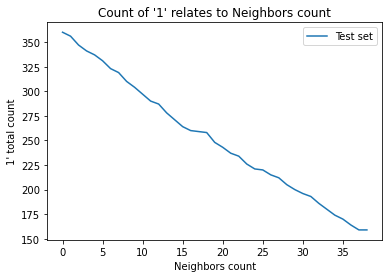

In [38]:
plt.plot(proba_count, label='Test set')
plt.xlabel('Neighbors count')
plt.ylabel("1' total count")
plt.legend()
plt.title("Count of '1' relates to Neighbors count")

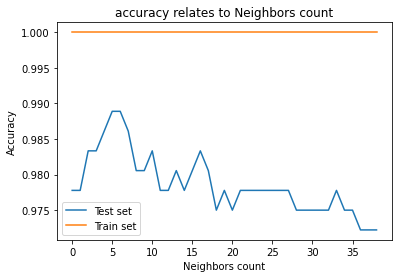

In [39]:
plt.plot(accuracy, label='Test set')
plt.plot(accuracy_trn, label='Train set')
plt.xlabel('Neighbors count')
plt.ylabel("Accuracy")
plt.title("accuracy relates to Neighbors count")
plt.legend()

< your thoughts > 
I conclude that the K-value (the count of neighbors) has a strong relationship with the prediction possibility of the KNN model.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [40]:
## your code
model = KNeighborsClassifier(n_neighbors=5, weights='distance')
model.fit(X_train, y_train)
accuracy_distance = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)

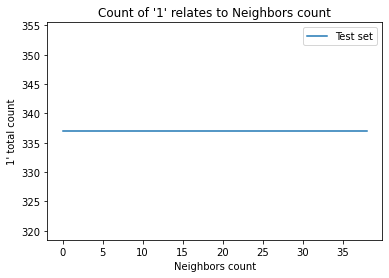

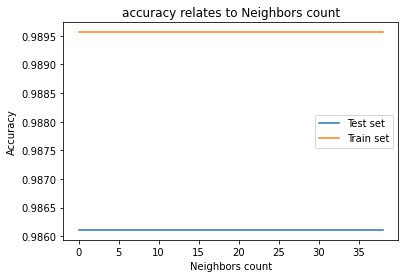

In [41]:
proba_count = []
accuracy = []
accuracy_trn = []
curr_proba = 0
for neighbors in range(1, 40):
    model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
    model.fit(X_train, y_train)
    curr_proba = model.predict_proba(X_test)
    proba_count.append(np.count_nonzero(curr_proba == 1))
    accuracy.append(metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test))
    accuracy_trn.append(metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train))

plt.plot(proba_count, label='Test set')
plt.xlabel('Neighbors count')
plt.ylabel("1' total count")
plt.legend()
plt.title("Count of '1' relates to Neighbors count")
plt.show()

plt.plot(accuracy, label='Test set')
plt.plot(accuracy_trn, label='Train set')
plt.xlabel('Neighbors count')
plt.ylabel("Accuracy")
plt.title("accuracy relates to Neighbors count")
plt.legend()
plt.show()

In [42]:
model = KNeighborsClassifier(n_neighbors=5, weights='uniform')
model.fit(X_train, y_train)
accuracy_uniform = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)

Text(0.5, 1.0, 'Model accuracy for Distance and Uniform correspondly')

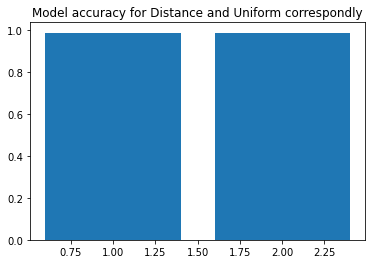

In [44]:
df = pd.DataFrame([accuracy_distance, accuracy_uniform])
plt.bar([1,2],[accuracy_distance, accuracy_uniform])
plt.title('Model accuracy for Distance and Uniform correspondly')

< your thoughts > The model quality with 'uniform' weights is not related to a count of neighbors. 

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts > There is Minkowski distance. I think this can be convenient for this task.


**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts > After my investigation of different distances, it would be great to know (or make some investigation) which distances can fit which task. I just can propose the different distances:
* Lp Minkowski distance measures : Manhattan, Chebyshev, Euclidean;
* L1Distance measures: Lorentzian, Canberra, Sorensen, Soergel,..
* Inner product distance measures: Jaccard, Cosine, Dice, Chord.
* Squared chord distance (SCD) measures
* SquaredL2distance measures

One more task is an investigation of algorithms (‘ball_tree’, ‘kd_tree’, ‘brute’) of KNN.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [45]:
import re
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression

In [46]:
PATH = "./data/"
print(PATH)

./data/


In [47]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [48]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [50]:
## your code
male_count = data[data.Sex == 'male'].shape[0]
female_count = data[data.Sex == 'female'].shape[0]
print("Total count of Males  = ", male_count)
print("Total count of Female = ", female_count)
survived_count = data[data.Survived == 1].shape[0]
unsurvived_count = data[data.Survived == 0].shape[0]
print("Total count of Survive  = ", survived_count)
print("Total count of Unsurvived = ", unsurvived_count)

Total count of Males  =  56114
Total count of Female =  43886
Total count of Survive  =  42774
Total count of Unsurvived =  57226


< your thoughts > Females have more chances to survive.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [51]:
data['Age'].describe(), data['Age'][data.Survived==1].describe()

(count    96708.000000
 mean        38.355472
 std         18.313556
 min          0.080000
 25%         25.000000
 50%         39.000000
 75%         53.000000
 max         87.000000
 Name: Age, dtype: float64,
 count    41418.000000
 mean        40.553799
 std         18.742172
 min          0.080000
 25%         27.000000
 50%         43.000000
 75%         55.000000
 max         87.000000
 Name: Age, dtype: float64)

<AxesSubplot:xlabel='Age', ylabel='Count'>

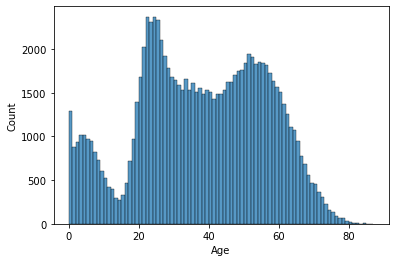

In [52]:
sns.histplot(data=data[['Survived', 'Age']], x = 'Age', binwidth=1)

<AxesSubplot:xlabel='Age', ylabel='Count'>

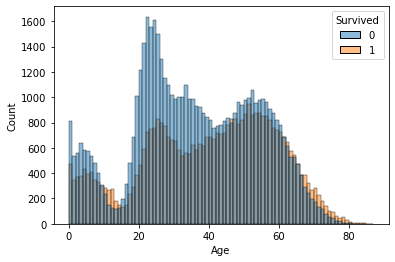

In [53]:
## your code
sns.histplot(data=data[['Survived', 'Age']], x = 'Age', hue='Survived', binwidth=1)

< your thoughts > the distribution is not changed a lot, but we can notice that younger peoples have less chances to be Survived than older ones.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [55]:
## your code
data['Pclass'].describe()

count    100000.000000
mean          2.106910
std           0.837727
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: Pclass, dtype: float64

<AxesSubplot:xlabel='Pclass', ylabel='Count'>

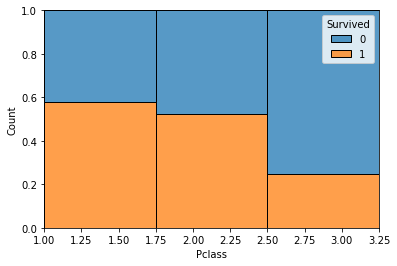

In [56]:
sns.histplot(data=data, x ='Pclass', hue="Survived", multiple="fill", binwidth=0.75 , shrink=1)

In [57]:
data['Embarked'].describe()

count     99750
unique        3
top           S
freq      72139
Name: Embarked, dtype: object

Text(0.5, 1.0, 'Passenger count by Embarked')

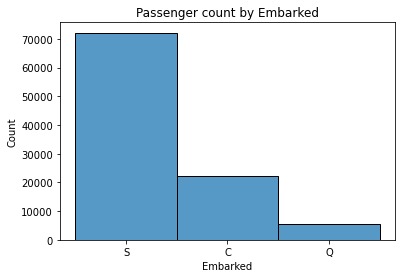

In [58]:
sns.histplot(x='Embarked', data=data)
plt.title("Passenger count by Embarked")

< your thoughts > 1-st class was "the safest".

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [59]:
## your code
total_rows = data.shape[0]
for column in data.columns:
    row_data = data[column]
    zero_counts = 100 * (row_data[row_data.isnull()].shape[0] / total_rows)
    print(f'{column} column has', zero_counts, "% of NULL items.")

Survived column has 0.0 % of NULL items.
Pclass column has 0.0 % of NULL items.
Name column has 0.0 % of NULL items.
Sex column has 0.0 % of NULL items.
Age column has 3.292 % of NULL items.
SibSp column has 0.0 % of NULL items.
Parch column has 0.0 % of NULL items.
Ticket column has 4.623 % of NULL items.
Fare column has 0.134 % of NULL items.
Cabin column has 67.866 % of NULL items.
Embarked column has 0.25 % of NULL items.


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts > I will replace NaN to Mean or Top value.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

Let's remove Data with zeros or NaN

In [82]:
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2,"Bell, Adele",female,62.00,0,0,PC 15008,14.86,D17243,C
99996,0,2,"Brown, Herman",male,66.00,0,0,13273,11.15,NaN,S
99997,0,3,"Childress, Charles",male,37.00,0,0,NaN,9.95,NaN,S


In [211]:
def prepsocess(df):
    #df = df.drop('Cabin', axis='columns')
    df = df.drop('Name', axis='columns')
    df = df.reset_index()
    res = pd.DataFrame(np.where(df.Sex == 'male', 0, 1))#
    res.rename(columns={0: 'Sex'}, inplace=True)
    df = df.drop('Sex', axis='columns')
    df = pd.concat([pd.DataFrame(df), pd.DataFrame(res)], axis=1)
    #S,C,Q
    res = pd.DataFrame(np.where(df.Embarked == 'S', 1, df.Embarked))
    res.rename(columns={0: 'Embarked'}, inplace=True)
    res = pd.DataFrame(np.where(res.Embarked == 'C', 2, res.Embarked))
    res.rename(columns={0: 'Embarked'}, inplace=True)
    res = pd.DataFrame(np.where(res.Embarked == 'Q', 3, res.Embarked))
    res.rename(columns={0: 'Embarked'}, inplace=True)
    df = df.drop('Embarked', axis='columns')
    df = pd.concat([pd.DataFrame(df), pd.DataFrame(res)], axis=1)

    res=[]
    for ticket in df.Ticket:
        s = re.findall(r'\d+', str(ticket))
        if s:
            res.append(int(s[0]))
        else:
            res.append(0)
    res = pd.DataFrame(res)
    res.rename(columns={0: 'Ticket'}, inplace=True)
    df = df.drop('Ticket', axis='columns')
    df = pd.concat([pd.DataFrame(df), pd.DataFrame(res)], axis=1)
    return df
    

In [212]:
df = data

In [213]:
df = df[(~(df.Name.isnull())) & (~(df.Sex.isnull())) & (~(df.Age.isnull())) & (~df.SibSp.isnull()) & (~df.Parch.isnull()) & (~(df.Ticket.isnull())) & (~(df.Fare.isnull())) & (~(df.Embarked.isnull()))]


In [214]:
df = prepsocess(df)
df = df.drop('PassengerId', axis='columns')

In [215]:
df.isna().sum()

Survived        0
Pclass          0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin       60999
Sex             0
Embarked        0
Ticket          0
dtype: int64

In [193]:
df

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Embarked,Ticket
0,0,3,0.33,1,2,71.29,0,1,457703
1,0,3,19.00,0,0,13.04,0,1,10866
2,1,3,25.00,0,0,7.76,0,1,427635
3,0,2,35.00,0,0,6.71,0,1,13363
4,0,3,7.00,0,0,9.77,0,1,5
...,...,...,...,...,...,...,...,...,...
91875,0,2,36.00,0,0,12.14,0,1,41343
91876,1,2,62.00,0,0,14.86,1,2,15008
91877,0,2,66.00,0,0,11.15,0,1,13273
91878,0,3,51.00,0,1,30.92,0,1,458654


In [216]:
df['Relatives'] = df['SibSp'] + df['Parch']
df['Fare_Per_Person'] = df['Fare']/(df['Relatives']+1)

In [218]:
df['Cabin'] = df['Cabin'].fillna("U0")
df['Deck'] = df['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
df.replace({'Deck':{'A':1,'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':9}}, inplace=True)

In [223]:
np.unique(df['Deck'])

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], dtype=object)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex,Ticket,Relatives,Fare_Per_Person,Deck
Survived,1.000000,-0.308358,0.108288,-0.006773,0.028008,0.197613,0.512802,-0.033191,0.014960,0.197601,-0.221055
Pclass,-0.308358,1.000000,-0.261693,-0.058822,-0.031775,-0.410294,-0.217320,0.043942,-0.056901,-0.364971,0.707435
Age,0.108288,-0.261693,1.000000,-0.114982,-0.131481,0.108064,0.084812,-0.020748,-0.158351,0.137095,-0.227007
SibSp,-0.006773,-0.058822,-0.114982,1.000000,0.218294,0.062697,0.028772,-0.007735,0.748670,-0.115201,-0.096024
Parch,0.028008,-0.031775,-0.131481,0.218294,1.000000,0.056186,0.093330,-0.004983,0.810385,-0.139791,-0.089911
Fare,0.197613,-0.410294,0.108064,0.062697,0.056186,1.000000,0.153842,-0.035752,0.075810,0.886073,-0.454345
Sex,0.512802,-0.217320,0.084812,0.028772,0.093330,0.153842,1.000000,-0.023065,0.080676,0.139643,-0.156009
Ticket,-0.033191,0.043942,-0.020748,-0.007735,-0.004983,-0.035752,-0.023065,1.000000,-0.008029,-0.031167,0.048347
Relatives,0.014960,-0.056901,-0.158351,0.748670,0.810385,0.075810,0.080676,-0.008029,1.000000,-0.164127,-0.118730
Fare_Per_Person,0.197601,-0.364971,0.137095,-0.115201,-0.139791,0.886073,0.139643,-0.031167,-0.164127,1.000000,-0.377570


<AxesSubplot:>

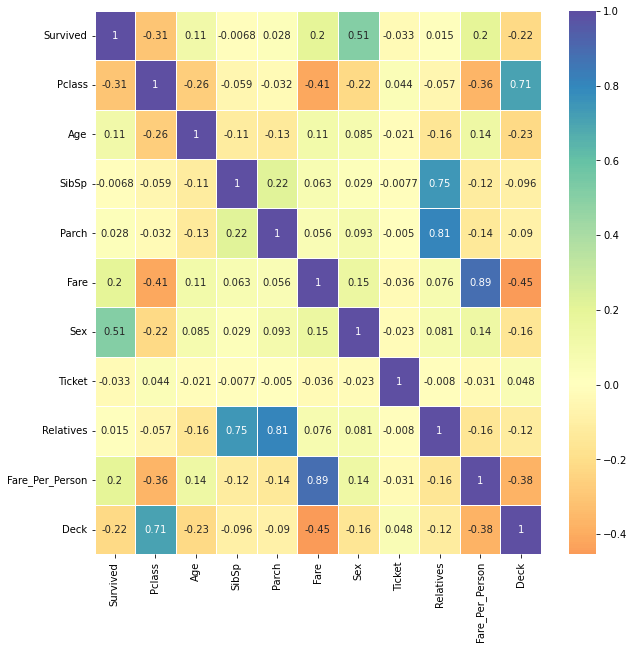

In [225]:
correlation_matrix = pd.DataFrame.corr(df) 
display(correlation_matrix)
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(correlation_matrix, center=0,  cmap="Spectral", annot = True, linewidths=.5, ax=ax)

Split the Data into a test and a train data.  

In [226]:
#features = ['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Sex', 'Embarked'] #, 'Ticket'] #''Pclass'', 
features = ['Pclass', 'Age', 'Fare_Per_Person', 'Relatives', 'Sex', 'Embarked', 'Deck'] #, 'Ticket'] #''Pclass'', 

In [227]:
X = df[features]
y = df['Survived']

In [228]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

**Make model**

In [93]:
SEED = 51

In [251]:
def replace_nan(rdf, column, replace_val):
    res = pd.DataFrame(rdf[column].replace(np.nan, replace_val))
    res.rename(columns={0: column}, inplace=True)
    rdf = rdf.drop(column, axis='columns')
    rdf = pd.concat([pd.DataFrame(rdf), pd.DataFrame(res)], axis=1)
    return rdf
    

In [163]:
def make_model_knn(n_neighbors=5, weights='uniform', alpha=0, penalty='L2'):
    # Lasso regression
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('cls', KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)),
        #('reg', regressor)
    ])

In [95]:
def make_model_logistic(tol=0.0001, C=1.0, alpha=0, penalty='L2'):
    # Lasso regression
    if penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('cls', LogisticRegression(tol=tol, C=C)),
       
        #('reg', regressor)
    ])

In [98]:
def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='best')         
    plt.show()

**KNN**

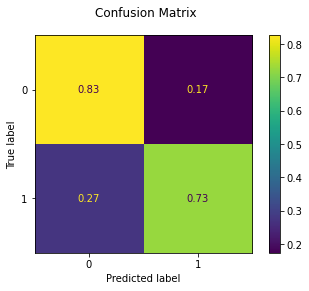

In [229]:
model = make_model_knn(n_neighbors=100, weights='uniform') #'distance/uniform') #make_model_knn()
model.fit(X_train, y_train)
lr_best_clf, lr_stats = fit_evaluate(model, X_train, y_train, X_test, y_test)
#accuracy = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
#print(lr_best_clf, lr_stats)

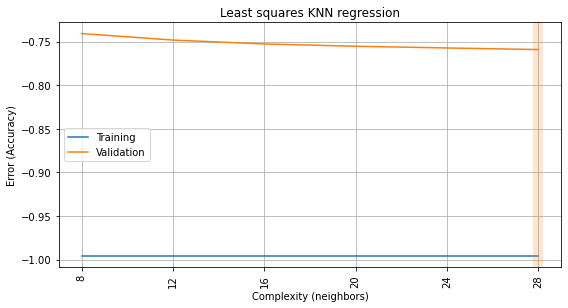

In [279]:
accur_train, accur_valid = [], []
neighbor_range = [8, 12, 16, 20, 24, 28] 
for neighbor in neighbor_range:
    results = cross_validate(make_model_knn(n_neighbors=neighbor, weights='distance'), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
    accur_train.append(-np.mean(results['train_score']))
    accur_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(neighbor_range, accur_train, accur_valid, xlabel='Complexity (neighbors)', ylabel='Error (Accuracy)',
                   title='Least squares KNN regression')

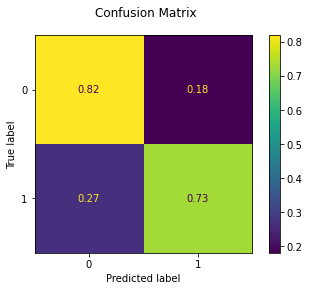

0.7808943342247652 0.7811275576839356


In [112]:
model_knn = make_model_knn(n_neighbors=50, weights='uniform') #'distance/uniform') #make_model_knn()
model_knn.fit(X_train, y_train)
lr_best_clf, lr_stats = fit_evaluate(model_knn, X_train, y_train, X_test, y_test)
accuracy = metrics.accuracy_score(y_pred=model_knn.predict(X_test), y_true=y_test)
print(lr_best_clf, lr_stats)

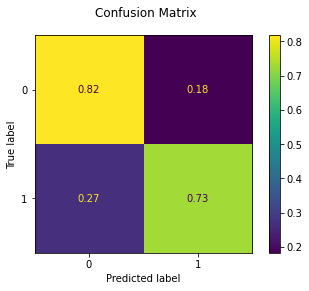

0.7803035014615337 0.7804382527934988


In [116]:
model_knn = make_model_knn(n_neighbors=70, weights='uniform') #'distance/uniform') #make_model_knn()
model_knn.fit(X_train, y_train)
lr_best_clf, lr_stats = fit_evaluate(model_knn, X_train, y_train, X_test, y_test)
accuracy = metrics.accuracy_score(y_pred=model_knn.predict(X_test), y_true=y_test)
print(lr_best_clf, lr_stats)

**Logistic Regression**

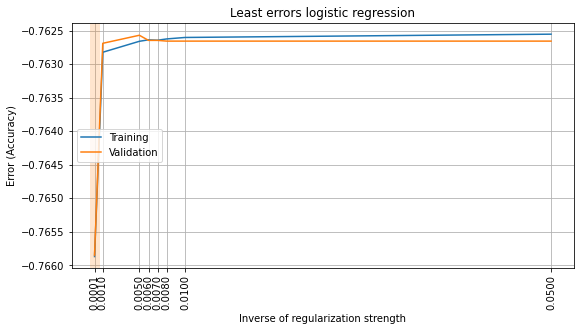

In [231]:
accur_train, accur_valid = [], []
c_range = [ 0.0001, 0.001, 0.005, 0.006, 0.007, 0.008, 0.01, 0.05]
for c in c_range:
    results = cross_validate(make_model_logistic(C=c), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='accuracy')
    accur_train.append(-np.mean(results['train_score']))
    accur_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(c_range, accur_train, accur_valid, xlabel='Inverse of regularization strength', ylabel='Error (Accuracy)',
                   title='Least errors logistic regression')

accuracy score: 0.7617136482368306 0.7642577274706138
f1 score      : 0.7170024720880257 0.7218083740046236


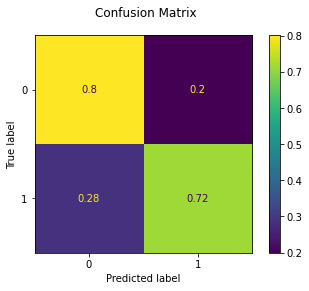

In [233]:
lr_model = make_model_logistic(C=0.007)
lr_model.fit(X_train, y_train)
train_acc = metrics.accuracy_score(y_pred=lr_model.predict(X_train), y_true=y_train)
test_acc = metrics.accuracy_score(y_pred=lr_model.predict(X_test), y_true=y_test)
print("accuracy score:", train_acc, test_acc)
train_f1 = metrics.f1_score(y_pred=lr_model.predict(X_train), y_true=y_train)
test_f1 = metrics.f1_score(y_pred=lr_model.predict(X_test), y_true=y_test)
print("f1 score      :", train_f1, test_f1)
lr_best_clf, lr_stats = fit_evaluate(lr_model, X_train, y_train, X_test, y_test)

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

I updated features list, but my score was not increased.

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [117]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [118]:
test_data

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C
...,...,...,...,...,...,...,...,...,...,...
199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q
199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S
199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S


In [263]:
tdf = prepsocess(test_data)

In [264]:
tdf

,PassengerId,Pclass,Age,SibSp,Parch,Fare,Cabin,Sex,Embarked,Ticket
0,100000,3,19.0,0,0,63.01,NaN,0,1,24745
1,100001,3,53.0,0,0,5.81,NaN,1,1,13264
2,100002,1,19.0,0,0,38.91,B15315,1,2,25990
3,100003,2,25.0,0,0,12.93,NaN,0,1,314011
4,100004,1,17.0,0,2,26.89,B22515,1,2,26203
...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,27.0,0,0,10.12,NaN,1,3,7686
99996,199996,1,59.0,1,0,68.31,NaN,0,1,13004
99997,199997,3,47.0,0,0,10.87,NaN,0,1,4383317
99998,199998,1,49.0,1,2,29.68,B20828,1,2,26988


In [265]:
tdf.isna().sum()

PassengerId        0
Pclass             0
Age             3487
SibSp              0
Parch              0
Fare             133
Cabin          70831
Sex                0
Embarked         277
Ticket             0
dtype: int64

In [266]:
tdf = replace_nan(tdf, 'Age', tdf['Age'].mean())

In [267]:
tdf = replace_nan(tdf, 'Fare', tdf['Fare'].mean())

In [268]:
tdf['Embarked'].describe()

count     99723
unique        3
top           1
freq      68842
Name: Embarked, dtype: int64

In [269]:
tdf = replace_nan(tdf, 'Embarked', 1)

In [270]:
tdf.isna().sum()

PassengerId        0
Pclass             0
SibSp              0
Parch              0
Cabin          70831
Sex                0
Ticket             0
Age                0
Fare               0
Embarked           0
dtype: int64

In [271]:
tdf['Relatives'] = tdf['SibSp'] + tdf['Parch']
tdf['Fare_Per_Person'] = tdf['Fare']/(tdf['Relatives']+1)

In [273]:
tdf = replace_nan(tdf, 'Cabin', 'U0')
tdf['Deck'] = tdf['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
tdf.replace({'Deck':{'A':1,'B':2, 'C':3, 'D':4, 'E':5, 'F':6, 'G':7, 'T':8, 'U':9}}, inplace=True)

In [274]:
tdf

,PassengerId,Pclass,SibSp,Parch,Sex,Ticket,Age,Fare,Embarked,Relatives,Fare_Per_Person,Cabin,Deck
0,100000,3,0,0,0,24745,19.0,63.01,1,0,63.010000,U0,9
1,100001,3,0,0,1,13264,53.0,5.81,1,0,5.810000,U0,9
2,100002,1,0,0,1,25990,19.0,38.91,2,0,38.910000,B15315,2
3,100003,2,0,0,0,314011,25.0,12.93,1,0,12.930000,U0,9
4,100004,1,0,2,1,26203,17.0,26.89,2,2,8.963333,B22515,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,0,0,1,7686,27.0,10.12,3,0,10.120000,U0,9
99996,199996,1,1,0,0,13004,59.0,68.31,1,1,34.155000,U0,9
99997,199997,3,0,0,0,4383317,47.0,10.87,1,0,10.870000,U0,9
99998,199998,1,1,2,1,26988,49.0,29.68,2,3,7.420000,B20828,2


In [275]:
y_pred=model.predict(tdf[features])

In [276]:
y_pred = pd.DataFrame(y_pred)
y_pred.rename(columns={0: 'Survived'}, inplace=True)
predict_df = pd.concat([pd.DataFrame(tdf), y_pred], axis=1)

In [277]:
predict_df[['PassengerId', 'Survived']].to_csv(os.path.join(PATH, 'titanic', 'predict_submission.csv'), index=False)

In [278]:
predict_df

,PassengerId,Pclass,SibSp,Parch,Sex,Ticket,Age,Fare,Embarked,Relatives,Fare_Per_Person,Cabin,Deck,Survived
0,100000,3,0,0,0,24745,19.0,63.01,1,0,63.010000,U0,9,0
1,100001,3,0,0,1,13264,53.0,5.81,1,0,5.810000,U0,9,0
2,100002,1,0,0,1,25990,19.0,38.91,2,0,38.910000,B15315,2,1
3,100003,2,0,0,0,314011,25.0,12.93,1,0,12.930000,U0,9,0
4,100004,1,0,2,1,26203,17.0,26.89,2,2,8.963333,B22515,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,0,0,1,7686,27.0,10.12,3,0,10.120000,U0,9,1
99996,199996,1,1,0,0,13004,59.0,68.31,1,1,34.155000,U0,9,0
99997,199997,3,0,0,0,4383317,47.0,10.87,1,0,10.870000,U0,9,0
99998,199998,1,1,2,1,26988,49.0,29.68,2,3,7.420000,B20828,2,1


My Score: 0.77183